In [84]:
import fiftyone as fo
import numpy as np

dataset = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split="train",
              label_types=["detections"],
              classes=["Cat"],
            #   max_samples=10,
          )

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v7-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import cv2

In [86]:
# try fewer samples
# n_samples = len(dataset)
n_samples = 500


x_size = 267
y_size = 326

In [87]:
# batching is not necessary if we're using fasterrcnn_resnet50_fpn.

batch_size = 25
# (267 x 326) is the number of pixels in the smallest images
# TODO: we downsize all images? i guess
batched_data = torch.zeros([n_samples// batch_size, batch_size, 3, y_size, x_size], dtype=torch.float32)
# batched_boxes = np.ndarray((n_samples // batch_size, batch_size, 4))
batched_targets = []

for batch_index in range(n_samples // batch_size):
    for i, sample in enumerate(dataset[batch_index * batch_size:(batch_index + 1) * batch_size]):
        batched_data[batch_index, i] = torch.from_numpy(cv2.resize(cv2.imread(sample['filepath']), (x_size, y_size)).transpose(2, 0, 1))
        batched_targets.append([])
        for detection in sample['ground_truth']['detections']:
                box = detection['bounding_box']

                x_min, y_min, width, height = box
                x_max = x_min + width
                y_max = y_min + height
                target = {
                    'boxes': torch.tensor([[x_min * x_size, y_min * y_size, x_max * x_size, y_max * y_size]], dtype=torch.float32),
                    'labels': torch.tensor([1 if detection['label'] == 'Cat' else 0], dtype=torch.int64),  # Assuming 1 is the label for 'Cat'
                }
                batched_targets[batch_index].append(target)


In [88]:
unbatched_data = torch.zeros([n_samples, 3, y_size, x_size], dtype=torch.float32)
# unbatched_boxes = np.ndarray((n_samples, 4))
targets = []
for i, sample in enumerate(dataset[:n_samples]):
    unbatched_data[i] = torch.from_numpy(cv2.resize(cv2.imread(sample['filepath']), (x_size, y_size)).transpose(2, 0, 1))
    for detection in sample['ground_truth']['detections']:
            box = detection['bounding_box']

            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            target = {
                'boxes': torch.tensor([[x_min * x_size, y_min * y_size, x_max * x_size, y_max * y_size]], dtype=torch.float32),
                'labels': torch.tensor([1 if detection['label'] == 'Cat' else 0], dtype=torch.int64),  # Assuming 1 is the label for 'Cat'
            }
            targets.append(target)

In [89]:
# def loss_fn(predictions, targets):
#     sum_losses = 0
#     for i in range(len(predictions)):
#         p_boxes = predictions[i]['boxes']
#         p_labels = predictions[i]['labels']
#         t_boxes = targets[i]['boxes']
#         t_labels = targets[i]['labels']

#         image_sum_losses = 0
#         n_boxes = min(len(p_boxes), len(t_boxes))
        
#         for i in range(n_boxes):
            


#     return sum_losses / len(predictions)

In [ ]:
# using documentation from https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
from sklearn.metrics import average_precision_score
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes = 2)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# model.eval()
# for i in range(min(10, n_samples // batch_size)):
for i in [0, 0, 0, 0, 0]:
    # optimizer.zero_grad()
    print(f"iteration {i}:\t\t",end="")
    output = model(batched_data[i], batched_targets[i])
    # output['loss_box_reg'].backward()
    # output['loss_classifier'].backward()
    # optimizer.step()
    # print(output)
    model.eval()
    print(f"loss_classifier: {output['loss_classifier'].item()},\t\t loss_box_reg: {output['loss_box_reg'].item()}")
    model.train()

iteration 0:		loss_classifier: 3.176400661468506,		 loss_box_reg: 0.7005183100700378
iteration 0:		loss_classifier: 3.176715850830078,		 loss_box_reg: 0.7005183100700378
iteration 0:		loss_classifier: 3.187598943710327,		 loss_box_reg: 0.7005183100700378
iteration 0:		loss_classifier: 3.0784010887145996,		 loss_box_reg: 0.7005183100700378
iteration 0:		loss_classifier: 3.1049160957336426,		 loss_box_reg: 0.7005183100700378


In [92]:
model.eval()
print(output)

{'loss_classifier': tensor(3.1049, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.7005, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.6785, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(1.6750, grad_fn=<DivBackward0>)}


In [93]:
import fiftyone as fo
import numpy as np

test_set = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split="test",
              label_types=["detections"],
              classes=["Cat"],
            #   max_samples=10,
          )

test_samples = 10

test_data = torch.zeros([test_samples, 3, y_size, x_size], dtype=torch.float32)
test_targets = []
for i, sample in enumerate(dataset[:test_samples]):
    test_data[i] = torch.from_numpy(cv2.resize(cv2.imread(sample['filepath']), (x_size, y_size)).transpose(2, 0, 1))

    boxes = []
    labels = []
    for detection in sample['ground_truth']['detections']:
        box = detection['bounding_box']

        x_min, y_min, width, height = box
        x_max = x_min + width
        y_max = y_min + height
        boxes.append([x_min * x_size, y_min * y_size, x_max * x_size, y_max * y_size])
        labels.append(1 if detection['label'] == 'Cat' else 0)  # Assuming 1 is the label for 'Cat'
    target = {
        'boxes': torch.tensor(boxes, dtype=torch.float32),
        'labels': torch.tensor(labels, dtype=torch.int64),
    }
    test_targets.append(target)

Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'open-images-v7-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [94]:
predictions = model(test_data)
print(predictions)

[{'boxes': tensor([[0.0000e+00, 3.0630e+02, 3.5800e+01, 3.0691e+02],
        [1.2030e+01, 8.0340e+01, 1.2085e+01, 8.3851e+01],
        [0.0000e+00, 1.0334e+02, 2.6700e+02, 1.0335e+02],
        [4.8342e+01, 3.3445e+01, 5.2706e+01, 3.3626e+01],
        [0.0000e+00, 1.9810e+02, 2.6700e+02, 2.0010e+02],
        [0.0000e+00, 3.1416e+02, 2.6700e+02, 3.2205e+02],
        [1.7411e+02, 1.2683e+01, 1.7425e+02, 1.2896e+01],
        [0.0000e+00, 2.6919e+02, 2.6700e+02, 2.7401e+02],
        [0.0000e+00, 3.1635e+02, 2.6700e+02, 3.1640e+02],
        [0.0000e+00, 3.0514e+02, 2.6700e+02, 3.0515e+02],
        [4.6930e+01, 3.5481e+01, 5.1785e+01, 3.6105e+01],
        [6.5150e+01, 9.2433e+00, 6.5188e+01, 9.2891e+00],
        [2.5428e+02, 9.4273e+01, 2.5593e+02, 9.5326e+01],
        [7.0457e+01, 1.6097e+02, 7.7630e+01, 1.7932e+02],
        [1.5528e+02, 6.5142e+01, 1.5603e+02, 6.5149e+01],
        [1.2512e+02, 1.0488e+02, 1.2515e+02, 1.0491e+02],
        [1.8447e+02, 6.3619e+01, 1.8481e+02, 6.4826e+01],
   

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score


acc_score = accuracy_score(test_targets, predictions)
print(f"Accuracy Score: {acc_score}")
avg_prec_score = average_precision_score(test_targets, predictions)
print(f"Average Precision Score: {avg_prec_score}")

[{'boxes': tensor([[1.6447e-02, 0.0000e+00, 4.9545e+00, 5.8836e+00],
        [0.0000e+00, 1.3027e-01, 7.8515e+00, 1.0843e+01],
        [1.8474e-02, 0.0000e+00, 1.0878e+01, 6.1059e+00],
        [2.9124e+00, 0.0000e+00, 1.3685e+01, 8.2955e+00],
        [2.4047e+02, 2.9613e+02, 2.6700e+02, 3.2574e+02],
        [5.4519e+01, 6.1147e-03, 8.4301e+01, 4.0133e+01],
        [6.5206e+01, 2.8949e-03, 9.4983e+01, 4.0133e+01],
        [1.7735e+02, 2.5445e-03, 2.0712e+02, 4.0133e+01],
        [1.3997e+02, 2.8185e-03, 1.6974e+02, 4.0133e+01],
        [9.1906e+01, 2.8185e-03, 1.2168e+02, 4.0133e+01],
        [1.2395e+02, 2.8185e-03, 1.5372e+02, 4.0133e+01],
        [1.0793e+02, 2.8185e-03, 1.3770e+02, 4.0133e+01],
        [1.5065e+02, 2.8185e-03, 1.8042e+02, 4.0133e+01],
        [1.6667e+02, 2.8185e-03, 1.9644e+02, 4.0133e+01],
        [7.5886e+01, 2.8185e-03, 1.0566e+02, 4.0133e+01],
        [1.9336e+02, 5.4522e-03, 2.2315e+02, 4.0153e+01],
        [2.7760e+01, 0.0000e+00, 5.7601e+01, 4.0163e+01],
   

ValueError: unknown is not supported

78


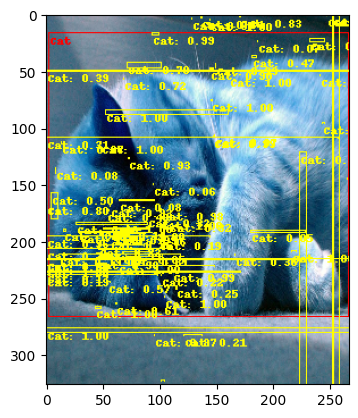

In [106]:
# from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

image_index = 8
# print(test_data[image_index], test_targets[image_index])

label_strings = []
for label in test_targets[image_index]['labels']:
    label_strings.append("Cat" if label == 1 else "")

prediction_label_strings = []
for i, label in enumerate(predictions[image_index]['labels']):
    prediction_label_strings.append(f"Cat: {predictions[image_index]['scores'][i]:0.2f}" if label == 1 else "")

print(len(prediction_label_strings))

output_image = draw_bounding_boxes(test_data[image_index].to(torch.uint8), test_targets[image_index]['boxes'], label_strings, colors="red")
output_image = draw_bounding_boxes(output_image, predictions[image_index]['boxes'], prediction_label_strings, colors="yellow")
plt.imshow(output_image.permute(1, 2, 0))